# Sagemaker/Jupyter to work with Redshift

## Pre-requisites

You will need:

* A redshift instance in a VPC. 
* A sagemaker notebook instance running this jupyter notebook in the same VPC as redshift.
* A security group on the redshift instance that will allow access from the sagemaker notebook instance

## Install libraries

In [1]:
!pip install psycopg2-binary
!pip install numpy
!pip install matplotlib
!pip install boto3

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Configure redshift connection

### The secure way

If you are planning on sharing this notebook or storing this notebook in version control you should never add any explicit credentials. In order to achieve this we will be using [AWS Secrets Manager](https://console.aws.amazon.com/secretsmanager/) to store our redshift credentials. 

#### Create new secret

Once on the [AWS Secrets Manager](https://console.aws.amazon.com/secretsmanager/) console:

* select: Store a new secret
* select: Credentials for Redshift cluster
* Enter username and password
* Select a Redshift cluster
* Click next

On the next page:

* Enter a human friendly name and description
* Click next

On the next page:

* Click next

On the next page:

* Review your selections
* Store secret

#### Get machine readable name of secret


#### Granting your sagemaker instance permission to use the secret

Obviously we wouldn't want anyone to be able to read the secret. Nor would we want your sagemaker notebook instance to be able to read all the secrets. To achieve both objectives, let's grant our notebook instance IAM permissions to access the secret:

On the [AWS Secrets Manager](https://console.aws.amazon.com/secretsmanager/) console click on your secret and find the Secret ARN. Replace the ARN information in the JSON below:

```
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Action": [
        "secretsmanager:GetResourcePolicy",
        "secretsmanager:GetSecretValue",
        "secretsmanager:DescribeSecret",
        "secretsmanager:ListSecretVersionIds"
      ],
      "Resource": [
        "arn:aws:secretsmanager:us-west-2:111122223333:secret:aes128-1a2b3c"
      ]
    }
  ]
}
```

Now attach this policy as an inline policy to the execution role for your Sagemaker notebook instance:

* Navigate to the [Amazon Sagemaker](https://us-west-2.console.aws.amazon.com/sagemaker/) console
* Select Notebook Instances
* Click on your notebook instance (the one running this notebook, most likely)
* Under "Permissions and Encryption" click on the IAM role link
* You should now be on an IAM console that allows you to "Add inline policy". Click on the link
* On the "Create Policy" page that opens, click JSON, and replace the JSON lines that show up with the block above. 
* Click review policy
* On the next page select a human friendly name for the policy and click "Create policy"

Finally paste the ARN for you secret in the code block below

In [2]:
# Put the ARN of your AWS Secrets Manager secret for your redshift cluster here:
secret_name="arn:aws:secretsmanager:us-west-2:111122223333:secret:aes128-1a2b3c"

# This will get the secret from AWS Secrets Manager. 
import boto3
import json

session = boto3.session.Session()
client = session.client(
    service_name='secretsmanager'
)

get_secret_value_response = client.get_secret_value(
    SecretId=secret_name
)

if 'SecretString' in get_secret_value_response:
    connection_info = json.loads(get_secret_value_response['SecretString'])
else:
    print("ERROR: no secret data found")

### The insecure way

Don't do this unless you are absolutely sure that nobody will ever see this notebook!

On the [redshift console page](https://console.aws.amazon.com/redshiftv2/home) select clusters, then your cluster, then properties and look a connection string from which to extract the information required below. Presumably you know your database credentials. 

In [3]:
# Please do not use this approach as it can expose credentials

# connection_info = {
#     "database" : '', 
#     "host"     : '', 
#     "port"     : '5439', 
#     "user"     : '', 
#     "password" : ''    
# }

### Establish the connection

In [4]:
# Sanity check for credentials
expected_keys = set(['user', 'password', 'host', 'database', 'port'])
if not expected_keys.issubset(connection_info.keys()):
    print("Expected values for ",expected_keys)
    print("Received values for ",set(connection_info.keys()))
    print("Please adjust query or assignment as required!")

In [5]:
# jdbc:redshift://HOST:PORT/DBNAME
import time
import psycopg2

con=psycopg2.connect(
    dbname   = connection_info["database"], 
    host     = connection_info["host"], 
    port     = connection_info["port"], 
    user     = connection_info["user"], 
    password = connection_info["password"]
)


## Run basic queries against the database

These queries make use of the [cursor class](https://www.psycopg.org/docs/cursor.html?highlight=arraysize). Also note that all of these queries do not persist to redshift unless you also call COMMIT.

### Creating tables etc.

In [6]:
# Set this to true to persist major changes to redshift. 
run_commits = False

# Set this to false if set run_commits to true and want to have the created schema/table persist
run_cleanup = True

This will query current timestamp from redshift. 
The beauty of this query is that it doesn't require any tables to be set up. 

In [7]:
cur = con.cursor()
cur.execute("SELECT sysdate")
res = cur.fetchall()
print(res)
cur.close()

[(datetime.datetime(2020, 5, 4, 22, 52, 10, 286561),)]


Create a schema. 

In [8]:
cur = con.cursor()
cur.execute("""
    CREATE SCHEMA IF NOT EXISTS pytest2
    """)
cur.close()

Check if we successfully created the schema

In [9]:
cur = con.cursor()
cur.execute("""
    select s.nspname as table_schema,
       s.oid as schema_id,  
       u.usename as owner
    from pg_catalog.pg_namespace s
    join pg_catalog.pg_user u on u.usesysid = s.nspowner
    order by table_schema;""")
res = cur.fetchall()
print("Schema pytest2 successfully created? ",'pytest2' in [x[0] for x in res])
print("All schemas:")
for ii in res:
    print(ii)
cur.close()

Schema pytest2 successfully created?  True
All schemas:
('aws_oracle_ext', 117417, 'rudpot')
('dummy', 125265, 'rudpot')
('information_schema', 17131, 'rdsdb')
('octank', 117022, 'rudpot')
('pg_catalog', 11, 'rdsdb')
('pg_internal', 100, 'rdsdb')
('pg_temp_1', 16924, 'rdsdb')
('pg_toast', 99, 'rdsdb')
('public', 2200, 'rdsdb')
('pytest1', 125273, 'rudpot')
('pytest2', 125356, 'rudpot')
('random', 158043, 'rudpot')
('wh', 158072, 'rudpot')


Create a table in new schema

In [10]:
cur = con.cursor()
cur.execute("""
    CREATE TABLE IF NOT EXISTS pytest2.pytest2 ( 
        id INTEGER primary key, 
        name CHARACTER VARYING, 
        created_at TIMESTAMP without time zone DEFAULT (getdate() at time zone 'utc')
        )
    """)
cur.close()

Insert some data - note that the timestamp is autogenerated based on default

In [11]:
cur = con.cursor()
cur.execute("""
    INSERT INTO pytest2.pytest2 VALUES ( 
        1, 'User1'
        )
    """)
time.sleep(5)
cur.execute("""
    INSERT INTO pytest2.pytest2 VALUES ( 
        2, 'User2'
        )
    """)
cur.close()

Check the results - note the difference of 5s in the final output value

In [12]:
cur = con.cursor()
cur.execute("SELECT * FROM pytest2.pytest2 LIMIT 2")
res = cur.fetchall()
print("Data retrieved:")
for ii in res:
    print(ii)
cur.close()


Data retrieved:
(1, 'User1', datetime.datetime(2020, 4, 2, 2, 6, 20))
(2, 'User2', datetime.datetime(2020, 4, 2, 2, 6, 25))


### Do some basic plotting

To see how to get data from the cursor. There's likely way better python libraries for this.

Purely for demonstration purposes we will insert a timestamp to use as x value and a number to use as y value

In [13]:
cur = con.cursor()
cur.execute("""
    CREATE TABLE IF NOT EXISTS pytest2.pytest3 ( 
        data_time TIMESTAMP without time zone DEFAULT (getdate() at time zone 'utc'),
        data_value DOUBLE PRECISION
        )
    """)
cur.execute("INSERT INTO pytest2.pytest3 VALUES ( 'Jan 1, 2018  10:00:00', 1 )")
cur.execute("INSERT INTO pytest2.pytest3 VALUES ( 'Jan 1, 2018  10:15:00', 4 )")
cur.execute("INSERT INTO pytest2.pytest3 VALUES ( 'Jan 1, 2018  10:30:00', 9 )")
cur.execute("INSERT INTO pytest2.pytest3 VALUES ( 'Jan 1, 2018  10:45:00', 16 )")
cur.execute("INSERT INTO pytest2.pytest3 VALUES ( 'Jan 1, 2018  11:00:00', 25 )")
cur.close()


The we read it back and use numpy and pyplot to help us with some plotting

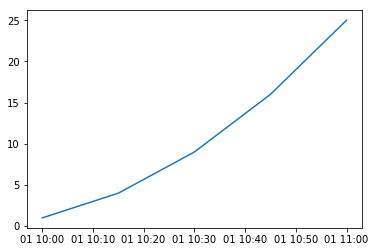

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

cur = con.cursor()
cur.execute("SELECT * FROM pytest2.pytest3")
res = cur.fetchall()
cur.close()
data=np.array(res)

plt.plot(data[:,0],data[:,1])
plt.show()

### Persist or delete

Persist changes to redshift if run_commits was set to true. If commit is called then any other tool querying your redshift database will now see your changes. Otherwise these changes are stuck in an open transaction.

Warning: if you keep the kernel running then any other tool trying to make changes to this schema will be blocking until the transaction is explicitly committed or until it is aborted when the connections is closed. This can become confusing if you keep re-creating connections during testing because then the old connections will not get closed/cleaned up until you restart the kernel.

In [15]:
if run_commits:
    cur = con.cursor()
    cur.execute("""
        COMMIT
        """)
    cur.close()

Clean up. If you didn't select `run_commits` then this is essentially a no-op because all changes were temporary anyway. Note that we are shortcutting table deletion here by using the CASCADE keyword on the schema drop.

In [16]:
if run_cleanup:
    cur = con.cursor()
    cur.execute("""
        DROP SCHEMA pytest2 CASCADE
        """)
    cur.execute("""
        select s.nspname as table_schema,
           s.oid as schema_id,  
           u.usename as owner
        from pg_catalog.pg_namespace s
        join pg_catalog.pg_user u on u.usesysid = s.nspowner
        order by table_schema;""")
    res = cur.fetchall()
    print("Schema pytest2 successfully deleted? ",not 'pytest2' in [x[0] for x in res])
    print("All schemas:")
    for ii in res:
        print(ii)
    cur.close()

Schema pytest2 successfully deleted?  True
All schemas:
('aws_oracle_ext', 117417, 'rudpot')
('dummy', 125265, 'rudpot')
('information_schema', 17131, 'rdsdb')
('octank', 117022, 'rudpot')
('pg_catalog', 11, 'rdsdb')
('pg_internal', 100, 'rdsdb')
('pg_temp_1', 16924, 'rdsdb')
('pg_toast', 99, 'rdsdb')
('public', 2200, 'rdsdb')
('pytest1', 125273, 'rudpot')
('random', 158043, 'rudpot')
('wh', 158072, 'rudpot')


Ensure all changes remain accessible in redshift for later review by setting `run_commits` to true and `run_cleanup` to false. 

In [17]:
if run_commits and run_cleanup:
    cur = con.cursor()
    cur.execute("""
        COMMIT
        """)
    cur.close()
    

## Cleanup

Close cursor to release any pending transactions 

In [18]:
con.close()